In [1]:
!pip install pandas seaborn scikit-image opencv-python scikit-learn tensorflow

  Using cached pandas-2.2.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached scikit_image-0.23.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached opencv_python-4.9.0.80-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached scikit_learn-1.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached tensorflow-2.16.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached matplotlib-3.8.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.8 kB)
  Using cached scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached imageio-2.34.0-py3-none-any.whl.metadata (4.9 kB)
  Using cached tifffile-2024.2.12-py3-none

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Torch
import torch
import torchvision
from torchvision import datasets,transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, Adagrad
from torch.autograd import Variable
import pathlib

In [3]:
transformer = transforms.Compose([transforms.Resize((150,150)),
                                  transforms.Grayscale(num_output_channels=1),
                                  transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(), # chnages from 0-255 to 0-1, numpy to tensors
                                  transforms.Normalize([0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5])
                                 ])

In [4]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

cuda:0


In [31]:
#DataLoader

batchSize=128
train_path = 'data/train'
train_loader = DataLoader(torchvision.datasets.ImageFolder(
                          train_path,
                          transform=transformer),
                          batch_size = batchSize,
                          shuffle=True)
val_path = 'data/val'
val_loader = DataLoader(torchvision.datasets.ImageFolder(
                          val_path,
                          transform=transformer),
                          batch_size = batchSize)

test_path = 'data/test'
test_loader = DataLoader(torchvision.datasets.ImageFolder(
                          test_path,
                          transform=transformer),
                          batch_size = batchSize,
                          shuffle=False)

In [32]:
total_images_train = len(train_loader.dataset)

print("Total number of images in the training dataset:", total_images_train)

total_images_test = len(test_loader.dataset)

print("Total number of images in the test dataset:", total_images_test)

total_images_val = len(val_loader.dataset)

Total number of images in the training dataset: 5217
Total number of images in the test dataset: 624


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, img_channels, class_count):
        super(CustomCNN, self).__init__()
        # 150×150
        
        # Convolutional layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(img_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #75×75
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #37×37
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #18×18
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #9×9
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), #4×4
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 256), 
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, class_count)
        )
        
    def forward(self, x):
        # Pass input through conv layers
        x = self.conv_layers(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Pass input through fc layers
        x = self.fc_layers(x)
        
        return x


In [34]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class CustomCNN(nn.Module):
#     def __init__(self, img_channels, class_count):
#         super(CustomCNN, self).__init__()
#         # 150×150
        
#         # Convolutional layers
#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(img_channels, 64, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.MaxPool2d(kernel_size=2, stride=2), #75×75
            
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.MaxPool2d(kernel_size=2, stride=2), #37×37
            
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.MaxPool2d(kernel_size=2, stride=2), #18×18
            
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.MaxPool2d(kernel_size=2, stride=2), #9×9
            
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.Sigmoid(),
#             nn.MaxPool2d(kernel_size=2, stride=2), #4×4
#         )
        
#         # Fully connected layers
#         self.fc_layers = nn.Sequential(
#             nn.Linear(512 * 4 * 4, 256),  # Adjust the linear layer input size according to your image input size
#             nn.Sigmoid(),
#             nn.Linear(256, 64),
#             nn.Sigmoid(),
#             nn.Linear(64, class_count)
#         )
        
#     def forward(self, x):
#         # Pass input through conv layers
#         x = self.conv_layers(x)
        
#         # Flatten
#         x = x.view(x.size(0), -1)
        
#         # Pass input through fc layers
#         x = self.fc_layers(x)
        
#         return x


In [35]:
model = CustomCNN(1, 2).to(device)

In [36]:
# optimizer =Adam(model.parameters(),lr = 0.00001,weight_decay=0.0001)
optimizer =Adagrad(model.parameters(),lr = 0.0001)
# loss_function = nn.CrossEntropyLoss()

In [37]:
weight_for_class_normal = 5291 / (1341 * 2)
weight_for_class_pneumonia = 5291 / (3875 * 2)

class_weights_tensor = torch.tensor([weight_for_class_normal, weight_for_class_pneumonia], dtype=torch.float32)
class_weights_tensor = class_weights_tensor.to(device)


# weighted loss function using to ensure that the model gives prority to the normal samples as well
#although they are much lesser in quantity
weighted_loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [50]:
num_epochs =20

In [51]:
from torch.autograd import Variable
best_accuracy=0.0
iterations=[]
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
    
for epoch in range(num_epochs):

    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0


    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()

        outputs=model(images)
        #using cross entropy loss (can explore BCE also)
        loss=weighted_loss_function(outputs,labels)
        #to calculate the loss wrt teh parameters and start backpropagation
        loss.backward()
        #to update the weights
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        # train_accuracy+=int(torch.sum(prediction==labels.data))
        train_accuracy += torch.sum(prediction == labels.data).item()

    #print(train_accuracy)
    train_accuracy=train_accuracy/len(train_loader.dataset)
    train_loss=train_loss/len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    # Evaluation on testing dataset
    model.eval()

    val_accuracy=0.0
    val_loss = 0.0 
    
    for i, (images,labels) in enumerate(val_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)

        batch_loss = weighted_loss_function(outputs, labels)
        val_loss += batch_loss.cpu().data * images.size(0)
        val_accuracy+=int(torch.sum(prediction==labels.data))

    val_accuracy=val_accuracy/total_images_val
    val_accuracies.append(val_accuracy)

    val_loss = val_loss / len(val_loader.dataset)  # Calculate average loss over the validation set
    val_losses.append(val_loss)


    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Val Accuracy: '+str(val_accuracy))

# torch.save(model.state_dict(), 'paths/model_adagrad_0001_64_relu.pth')

Epoch: 0 Train Loss: tensor(0.2319) Train Accuracy: 0.9045428407130535 Val Accuracy: 0.5625
Epoch: 1 Train Loss: tensor(0.2261) Train Accuracy: 0.9047345217557984 Val Accuracy: 0.6875
Epoch: 2 Train Loss: tensor(0.2229) Train Accuracy: 0.9079930994824612 Val Accuracy: 0.6875
Epoch: 3 Train Loss: tensor(0.2147) Train Accuracy: 0.9110599961663791 Val Accuracy: 0.6875
Epoch: 4 Train Loss: tensor(0.2146) Train Accuracy: 0.9122100824228484 Val Accuracy: 0.6875
Epoch: 5 Train Loss: tensor(0.2109) Train Accuracy: 0.9131684876365728 Val Accuracy: 0.75
Epoch: 6 Train Loss: tensor(0.2090) Train Accuracy: 0.9145102549357869 Val Accuracy: 0.6875
Epoch: 7 Train Loss: tensor(0.2024) Train Accuracy: 0.9206440483036228 Val Accuracy: 0.625
Epoch: 8 Train Loss: tensor(0.2019) Train Accuracy: 0.9179605137051946 Val Accuracy: 0.6875
Epoch: 9 Train Loss: tensor(0.1974) Train Accuracy: 0.9223691776883266 Val Accuracy: 0.625
Epoch: 10 Train Loss: tensor(0.1960) Train Accuracy: 0.9223691776883266 Val Accuracy

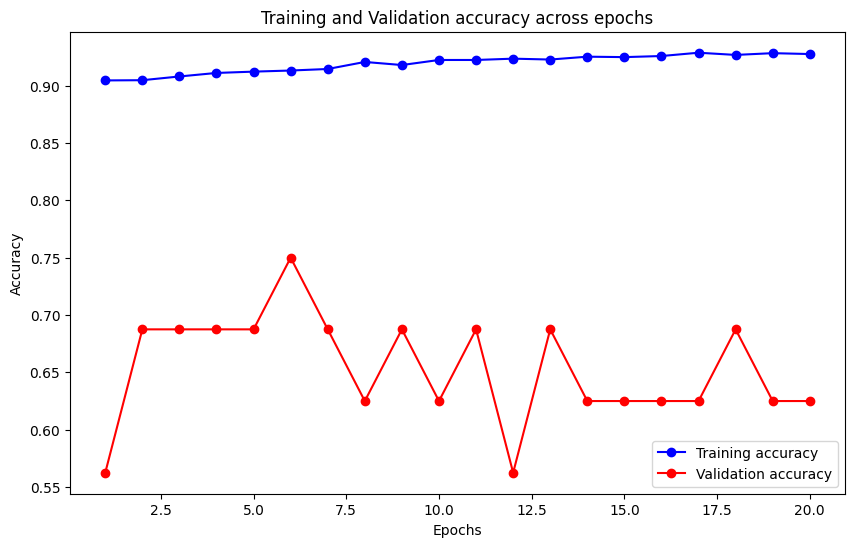

In [53]:
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
plt.title('Training and Validation accuracy across epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

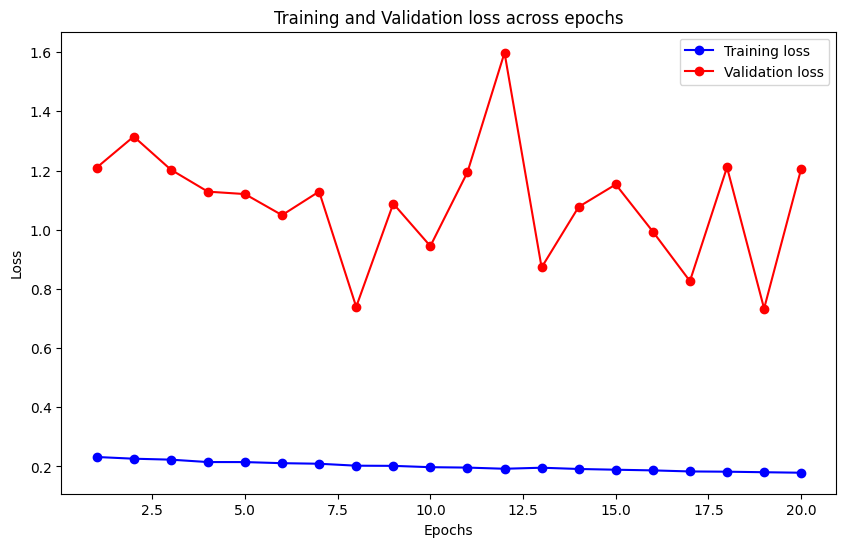

In [54]:
epochs = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'bo-', label='Training loss')
plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
plt.title('Training and Validation loss across epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()